## <font color = 'orange'> **05-machine_learning2 branch**

Trying to run it with parallelization and in chunks... not working

In [2]:
import sys
import pandas as pd
import numpy as np
import sqlite3
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import psutil

# Importing WeatherAnalyzer from the analyze_data script
sys.path.append('/workspaces/weather-scraper-analyzer/src/03-data_analysis')
from analyze_data import WeatherAnalyzer

# Setting up the connection to the database
conn = sqlite3.connect(r"/workspaces/weather-scraper-analyzer/data/weather_data.db")
daily_df = pd.read_sql(r"SELECT * FROM daily_data", conn)

# Dropping the index column and setting up the date
daily_df = daily_df.drop(columns='index')
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df = daily_df.set_index('date')
daily_df.index = pd.to_datetime(daily_df.index).to_period('D').to_timestamp()

# Initialize WeatherAnalyzer (if you need it for further analysis)
analyzer = WeatherAnalyzer(None, daily_df)

# Extract the necessary weather variables
variables = {
    "Temperature": daily_df['temperature_2m_mean_C'].dropna(),
    "Precipitation": daily_df['precipitation_sum_mm'].dropna(),
    "Wind Speed": daily_df['wind_speed_10m_max_kmh'].dropna()
}

# Function to log and display resource usage
def log_resource_usage(step):
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_info = psutil.virtual_memory()
    memory_usage = memory_info.percent
    print(f"[{step}] CPU Usage: {cpu_usage}% | Memory Usage: {memory_usage}%")

# Function to fit SARIMA model
def fit_sarima_model(series_chunk, order, seasonal_order):
    log_resource_usage("Before fitting SARIMA model")
    model = SARIMAX(series_chunk, order=order, seasonal_order=seasonal_order)
    result = model.fit(disp=False)
    log_resource_usage("After fitting SARIMA model")
    return result

# Function to fit Prophet model
def fit_prophet_model(series_chunk, variable_name):
    # Preparing the data for Prophet
    df = series_chunk.reset_index()
    df.columns = ['ds', 'y']

    log_resource_usage(f"Before fitting Prophet model for {variable_name}")
    model = Prophet()
    model.fit(df)
    log_resource_usage(f"After fitting Prophet model for {variable_name}")

    # Forecast for the next 6 years
    future = model.make_future_dataframe(periods=6 * 365)
    forecast = model.predict(future)

    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], variable_name

# Simplified SARIMA model configuration
p, d, q = 0, 1, 1  # Simplified ARIMA component
P, D, Q, s = 0, 1, 1, 365  # Simplified seasonal component with yearly seasonality

# Split each series into 5 chunks
chunks = 4
split_series = {var_name: np.array_split(series, chunks) for var_name, series in variables.items()}

# Measure the start time and log initial resource usage
start_time = datetime.now()
log_resource_usage("Start of the process")

# Applying parallelization for SARIMA model on each chunk
sarima_results = []
for var_name, series_chunks in split_series.items():
    results = Parallel(n_jobs=2)(
        delayed(fit_sarima_model)(chunk, (p, d, q), (P, D, Q, s))
        for chunk in series_chunks
    )
    sarima_results.append((var_name, results))

# Applying parallelization for Prophet model on each chunk
prophet_results = []
for var_name, series_chunks in split_series.items():
    results = Parallel(n_jobs=2)(
        delayed(fit_prophet_model)(chunk, var_name)
        for chunk in series_chunks
    )
    prophet_results.append((var_name, results))

# Measure the end time and print the duration and final resource usage
end_time = datetime.now()
print(f"Model fitting duration with parallelization: {end_time - start_time}")
log_resource_usage("End of the process")

# Plotting SARIMA Forecasts
for var_name, results in sarima_results:
    for i, result in enumerate(results):
        forecast_steps = 6 * 365
        sarima_forecast = result.get_forecast(steps=forecast_steps)
        forecast_mean = sarima_forecast.predicted_mean
        forecast_ci = sarima_forecast.conf_int()

        plt.figure(figsize=(14, 7))
        plt.plot(split_series[var_name][i].index, split_series[var_name][i], label="Historical Data", color="blue")
        plt.plot(pd.date_range(start='2025-01-01', periods=forecast_steps), forecast_mean, color='orange', label="Forecast")
        plt.fill_between(pd.date_range(start='2025-01-01', periods=forecast_steps),
                         forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.3, label="Confidence Interval")
        plt.title(f"SARIMA Forecast for {var_name} (Chunk {i+1})")
        plt.xlabel("Date")
        plt.ylabel(var_name)
        plt.legend()
        plt.show()

# Plotting Prophet Forecasts
for var_name, results in prophet_results:
    for i, (forecast, _) in enumerate(results):
        plt.figure(figsize=(14, 7))
        plt.plot(forecast['ds'], forecast['yhat'], color='green', label="Forecast")
        plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='green', alpha=0.3, label="Confidence Interval")
        plt.title(f"Prophet Forecast for {var_name} (Chunk {i+1})")
        plt.xlabel("Date")
        plt.ylabel(var_name)
        plt.legend()
        plt.show()


/home/weather_project_user/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


[Start of the process] CPU Usage: 0.8% | Memory Usage: 14.0%
[Before fitting SARIMA model] CPU Usage: 0.3% | Memory Usage: 15.2%[Before fitting SARIMA model] CPU Usage: 0.3% | Memory Usage: 15.2%



TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [1]:
daily_df.shape

NameError: name 'daily_df' is not defined

#### <font color = 'lightblue'>**Running  on SPARK.**
Not working

In [10]:
from pyspark.sql import SparkSession
from pysparkling import H2OContext
import h2o
from h2o.automl import H2OAutoML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("H2OContext Test") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Initialize H2O Context
h2o_context = H2OContext.getOrCreate(spark)
print("H2OContext successfully created!")

# Step 2: Load Your Data into a Spark DataFrame
conn = sqlite3.connect(r"/workspaces/weather-scraper-analyzer/data/weather_data.db")
daily_df = pd.read_sql(r"SELECT * FROM daily_data", conn)
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df = daily_df.set_index('date')

# Convert pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(daily_df.reset_index())

# Step 3: Convert Spark DataFrame to H2OFrame
h2o_frame = h2o_context.as_h2o_frame(spark_df)

# Step 4: Train H2O AutoML for Each Weather Variable
variables = ["temperature_2m_mean_C", "precipitation_sum_mm", "wind_speed_10m_max_kmh"]
results = {}

for var in variables:
    print(f"Training AutoML model for {var}...")
    
    # Prepare H2OFrame for training
    h2o_frame["date"] = h2o_frame["date"].asfactor()  # Convert date to categorical if needed
    aml = H2OAutoML(max_models=20, seed=42, exclude_algos=["DeepLearning"])  # Limiting to faster models
    
    # Train AutoML model
    aml.train(y=var, training_frame=h2o_frame)
    
    # Save the leaderboard and the best model
    results[var] = aml.leader
    
    # Generate forecasts
    future_df = pd.date_range(start=daily_df.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')
    future_h2o = h2o.H2OFrame(pd.DataFrame({'date': future_df}))
    predictions = aml.leader.predict(future_h2o).as_data_frame()

    # Plotting the results
    plt.figure(figsize=(14, 7))
    plt.plot(daily_df.index, daily_df[var], label="Historical Data", color="blue")
    plt.plot(future_df, predictions['predict'], label="Forecast", color="orange")
    plt.fill_between(future_df, predictions['predict'] - 1.96 * predictions['se'], 
                     predictions['predict'] + 1.96 * predictions['se'], 
                     color='orange', alpha=0.3, label="Confidence Interval")
    plt.title(f"{var} Forecast (Next Year)")
    plt.xlabel("Date")
    plt.ylabel(var)
    plt.legend()
    plt.show()

# Measure the end time and print the duration
end_time = datetime.now()
print(f"Total Duration: {end_time - start_time}")


ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
from pyspark.sql import SparkSession
from pysparkling import H2OContext  # Use only `pysparkling`

# Step 1: Initialize Spark Session
spark = SparkSession.builder \
    .appName("H2OContext Test") \
    .config("spark.ext.h2o.fail.on.unsupported.spark.param", "false") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# Step 2: Initialize H2OContext
try:
    # Attempt to create H2OContext
    h2o_context = H2OContext.getOrCreate()
    print("H2OContext successfully created!")
except Exception as e:
    # Catch and print any errors
    print(f"Error initializing H2OContext: {e}")


11-03 13:05:28.362 172.17.0.2:54321      1193     Thread-4  WARN org.apache.spark.h2o.backends.internal.InternalH2OBackend: Increasing 'spark.locality.wait' to value 0 (Infinitive) as we need to ensure we run on the nodes with H2O
11-03 13:05:28.374 172.17.0.2:54321      1193     Thread-4  INFO org.apache.spark.SparkContext: Added file /tmp/spark-3a575ca9-ceca-4d6a-ba64-b027de4db4bc/hdfs_conf9718240137145431050.xml at file:/tmp/spark-3a575ca9-ceca-4d6a-ba64-b027de4db4bc/hdfs_conf9718240137145431050.xml with timestamp 1730639128374
11-03 13:05:28.374 172.17.0.2:54321      1193     Thread-4  INFO org.apache.spark.util.Utils: Copying /tmp/spark-3a575ca9-ceca-4d6a-ba64-b027de4db4bc/hdfs_conf9718240137145431050.xml to /tmp/spark-3a575ca9-ceca-4d6a-ba64-b027de4db4bc/userFiles-c2157cb1-7d07-4eff-be66-13af3fa28e04/hdfs_conf9718240137145431050.xml
11-03 13:05:28.380 172.17.0.2:54321      1193     Thread-4  INFO ai.h2o.sparkling.H2OContext: Sparkling Water version: 3.46.0.5-1-3.5
11-03 13:05:28.

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/weather_project_user/venv/lib/python3.12/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/weather_project_user/venv/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/weather_project_user/venv/lib/python3.12/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Error initializing H2OContext: An error occurred while calling o51.getOrCreate


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/weather_project_user/venv/lib/python3.12/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/weather_project_user/venv/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/weather_project_user/venv/lib/python3.12/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


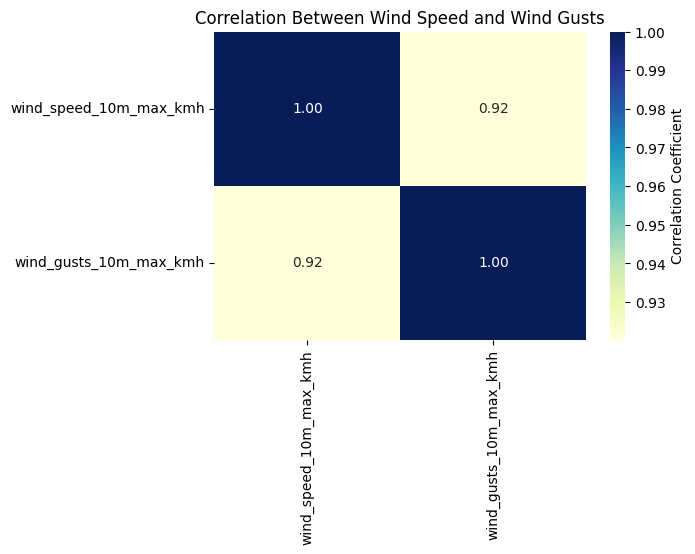

In [6]:
# Calculating the correlation matrix for wind-related features to see if we include them both or not (if they highly correlate, it's not valuable to include them both maybe)
wind_features = daily_df[['wind_speed_10m_max_kmh', 'wind_gusts_10m_max_kmh']]
correlation_matrix = wind_features.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Correlation Coefficient'}, fmt=".2f")
plt.title("Correlation Between Wind Speed and Wind Gusts")
plt.show()

Running normal... I'm dying to see how MUCH time it's gonna cost me

130 min elapsed still not beyond the first variable for SARIMA. I am going only for PROPHET in the next cell

In [ ]:
import sys
import pandas as pd
import numpy as np
import sqlite3
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from datetime import datetime
import matplotlib.pyplot as plt
import psutil

# Importing WeatherAnalyzer from the analyze_data script
sys.path.append('/workspaces/weather-scraper-analyzer/src/03-data_analysis')
from analyze_data import WeatherAnalyzer

# Setting up the connection to the database
conn = sqlite3.connect(r"/workspaces/weather-scraper-analyzer/data/weather_data.db")
daily_df = pd.read_sql(r"SELECT * FROM daily_data", conn)

# Dropping the index column and setting up the date
daily_df = daily_df.drop(columns='index')
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df = daily_df.set_index('date')
daily_df.index = pd.to_datetime(daily_df.index).to_period('D').to_timestamp()

# Initialize WeatherAnalyzer (if you need it for further analysis)
analyzer = WeatherAnalyzer(None, daily_df)

# Extract the necessary weather variables
variables = {
    "Temperature": daily_df['temperature_2m_mean_C'].dropna(),
    "Precipitation": daily_df['precipitation_sum_mm'].dropna(),
    "Wind Speed": daily_df['wind_speed_10m_max_kmh'].dropna()
}

# Function to log and display resource usage
def log_resource_usage(step):
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_info = psutil.virtual_memory()
    memory_usage = memory_info.percent
    print(f"[{step}] CPU Usage: {cpu_usage}% | Memory Usage: {memory_usage}%")

# Function to fit SARIMA model
def fit_sarima_model(series, order, seasonal_order):
    log_resource_usage("Before fitting SARIMA model")
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
    result = model.fit(disp=False)
    log_resource_usage("After fitting SARIMA model")
    return result

# Function to fit Prophet model
def fit_prophet_model(series, variable_name):
    # Preparing the data for Prophet
    df = series.reset_index()
    df.columns = ['ds', 'y']

    log_resource_usage(f"Before fitting Prophet model for {variable_name}")
    model = Prophet()
    model.fit(df)
    log_resource_usage(f"After fitting Prophet model for {variable_name}")

    # Forecast for the next 6 years
    future = model.make_future_dataframe(periods=6 * 365)
    forecast = model.predict(future)

    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], variable_name

# Simplified SARIMA model configuration
p, d, q = 0, 1, 1  # Simplified ARIMA component
P, D, Q, s = 0, 1, 1, 365  # Simplified seasonal component with yearly seasonality

# Measure the start time and log initial resource usage
start_time = datetime.now()
log_resource_usage("Start of the process")

# Fitting SARIMA model for each variable
sarima_results = {}
for var_name, series in variables.items():
    sarima_results[var_name] = fit_sarima_model(series, (p, d, q), (P, D, Q, s))

# Fitting Prophet model for each variable
prophet_results = {}
for var_name, series in variables.items():
    prophet_results[var_name] = fit_prophet_model(series, var_name)

# Measure the end time and print the duration and final resource usage
end_time = datetime.now()
print(f"Model fitting duration: {end_time - start_time}")
log_resource_usage("End of the process")

# Plotting SARIMA Forecasts
for var_name, result in sarima_results.items():
    forecast_steps = 6 * 365
    sarima_forecast = result.get_forecast(steps=forecast_steps)
    forecast_mean = sarima_forecast.predicted_mean
    forecast_ci = sarima_forecast.conf_int()

    plt.figure(figsize=(14, 7))
    plt.plot(variables[var_name].index[-5*365:], variables[var_name][-5*365:], label="Historical Data", color="blue")
    plt.plot(pd.date_range(start='2025-01-01', periods=forecast_steps), forecast_mean, color='orange', label="Forecast")
    plt.fill_between(pd.date_range(start='2025-01-01', periods=forecast_steps),
                     forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.3, label="Confidence Interval")
    plt.title(f"SARIMA Forecast for {var_name} (2025 to 2030)")
    plt.xlabel("Date")
    plt.ylabel(var_name)
    plt.legend()
    plt.show()

# Plotting Prophet Forecasts
for var_name, (forecast, _) in prophet_results.items():
    plt.figure(figsize=(14, 7))
    plt.plot(forecast['ds'], forecast['yhat'], color='green', label="Forecast")
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='green', alpha=0.3, label="Confidence Interval")
    plt.title(f"Prophet Forecast for {var_name} (2025 to 2030)")
    plt.xlabel("Date")
    plt.ylabel(var_name)
    plt.legend()
    plt.show()


[Start of the process] CPU Usage: 1.4% | Memory Usage: 14.4%
[Before fitting SARIMA model] CPU Usage: 0.3% | Memory Usage: 14.4%


#### Ramane asta <font color = 'green'> **PROPHET using days to predict**

[Start of the process] CPU Usage: 0.2% | Memory Usage: 21.1%
[Before fitting Prophet model for Temperature] CPU Usage: 0.5% | Memory Usage: 21.1%


08:54:07 - cmdstanpy - INFO - Chain [1] start processing
08:54:07 - cmdstanpy - INFO - Chain [1] done processing


[After fitting Prophet model for Temperature] CPU Usage: 0.1% | Memory Usage: 21.1%

Temperature Forecast Confidence Interval (First 10 rows):
          ds  yhat_lower  yhat_upper
0 2000-01-01   -3.287128    6.206021
1 2000-01-02   -3.174732    5.748437
2 2000-01-03   -3.408209    5.889557
3 2000-01-04   -3.314719    5.956957
4 2000-01-05   -3.320110    5.559158
5 2000-01-06   -2.961605    5.718994
6 2000-01-07   -3.283244    6.079065
7 2000-01-08   -3.135033    6.327606
8 2000-01-09   -3.075350    5.765128
9 2000-01-10   -3.411690    5.894595
[Before fitting Prophet model for Precipitation] CPU Usage: 0.8% | Memory Usage: 20.5%


08:54:12 - cmdstanpy - INFO - Chain [1] start processing
08:54:12 - cmdstanpy - INFO - Chain [1] done processing


[After fitting Prophet model for Precipitation] CPU Usage: 0.1% | Memory Usage: 20.5%

Precipitation Forecast Confidence Interval (First 10 rows):
          ds  yhat_lower  yhat_upper
0 2000-01-01   -3.872200    6.310549
1 2000-01-02   -3.892947    6.602780
2 2000-01-03   -3.638234    6.376638
3 2000-01-04   -4.149859    6.769503
4 2000-01-05   -4.195640    6.948272
5 2000-01-06   -4.233919    6.011860
6 2000-01-07   -4.890895    5.804231
7 2000-01-08   -4.071565    6.501733
8 2000-01-09   -4.099336    6.362231
9 2000-01-10   -3.812717    6.663193
[Before fitting Prophet model for Wind Speed] CPU Usage: 0.2% | Memory Usage: 20.5%


08:54:16 - cmdstanpy - INFO - Chain [1] start processing
08:54:17 - cmdstanpy - INFO - Chain [1] done processing


[After fitting Prophet model for Wind Speed] CPU Usage: 0.0% | Memory Usage: 20.5%

Wind Speed Forecast Confidence Interval (First 10 rows):
          ds  yhat_lower  yhat_upper
0 2000-01-01    6.678413   19.956070
1 2000-01-02    6.733785   20.224098
2 2000-01-03    6.975930   19.909602
3 2000-01-04    6.655040   19.803193
4 2000-01-05    6.605609   19.994400
5 2000-01-06    6.431568   19.566703
6 2000-01-07    6.118627   19.483967
7 2000-01-08    6.472644   20.459295
8 2000-01-09    7.394128   20.069561
9 2000-01-10    6.882077   19.922966
Model fitting duration: 0:00:14.869467
[End of the process] CPU Usage: 0.1% | Memory Usage: 20.5%


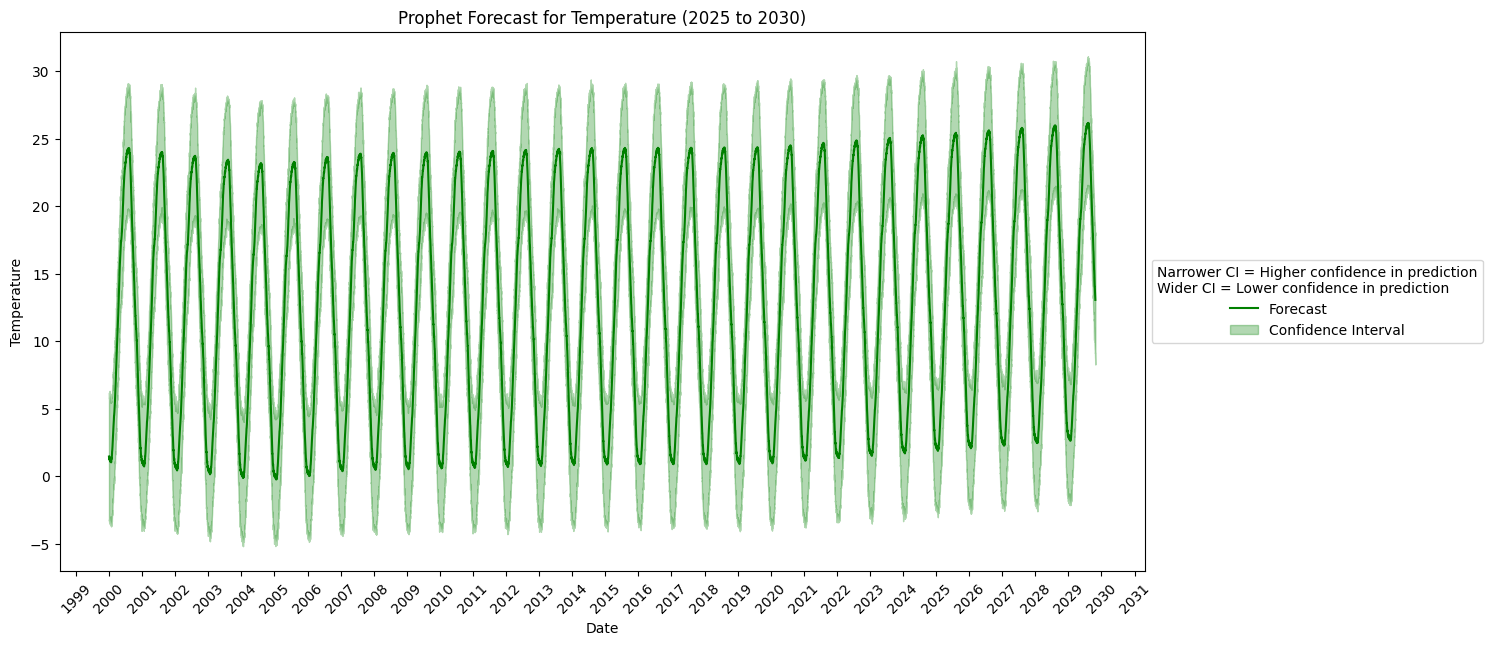

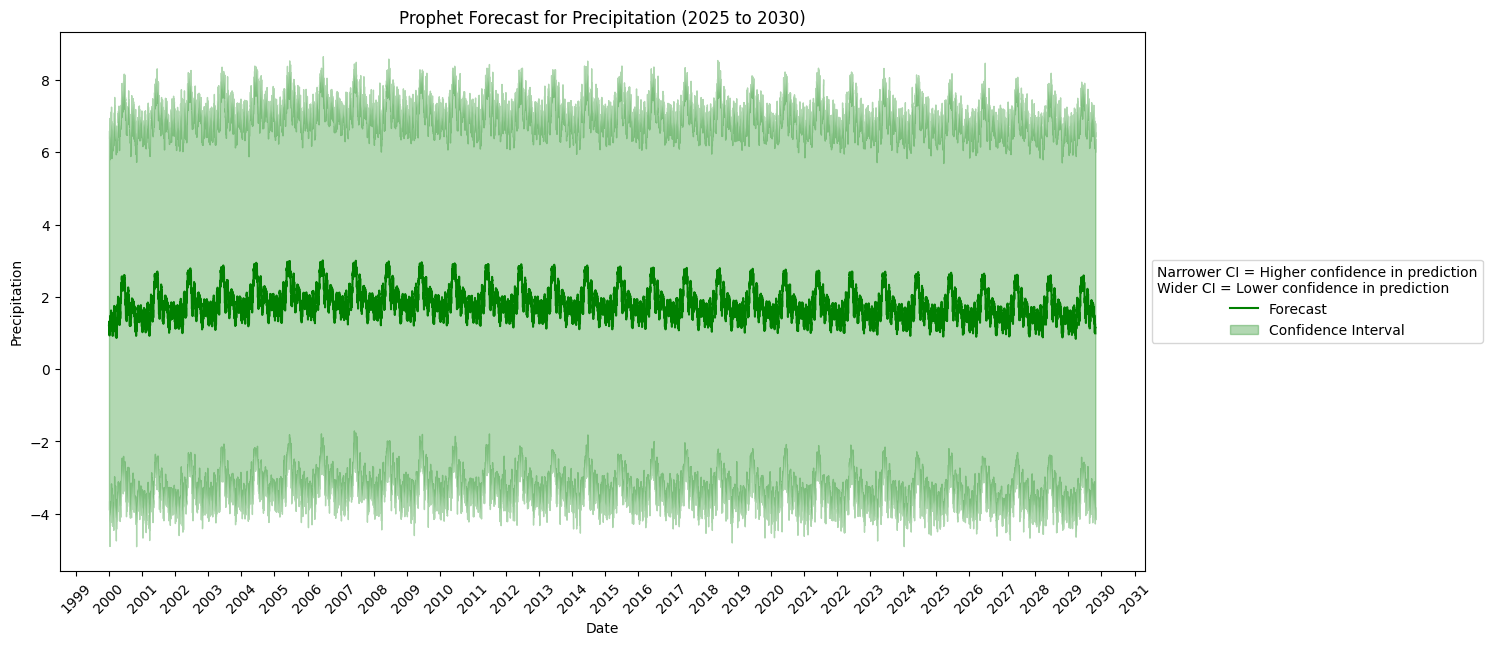

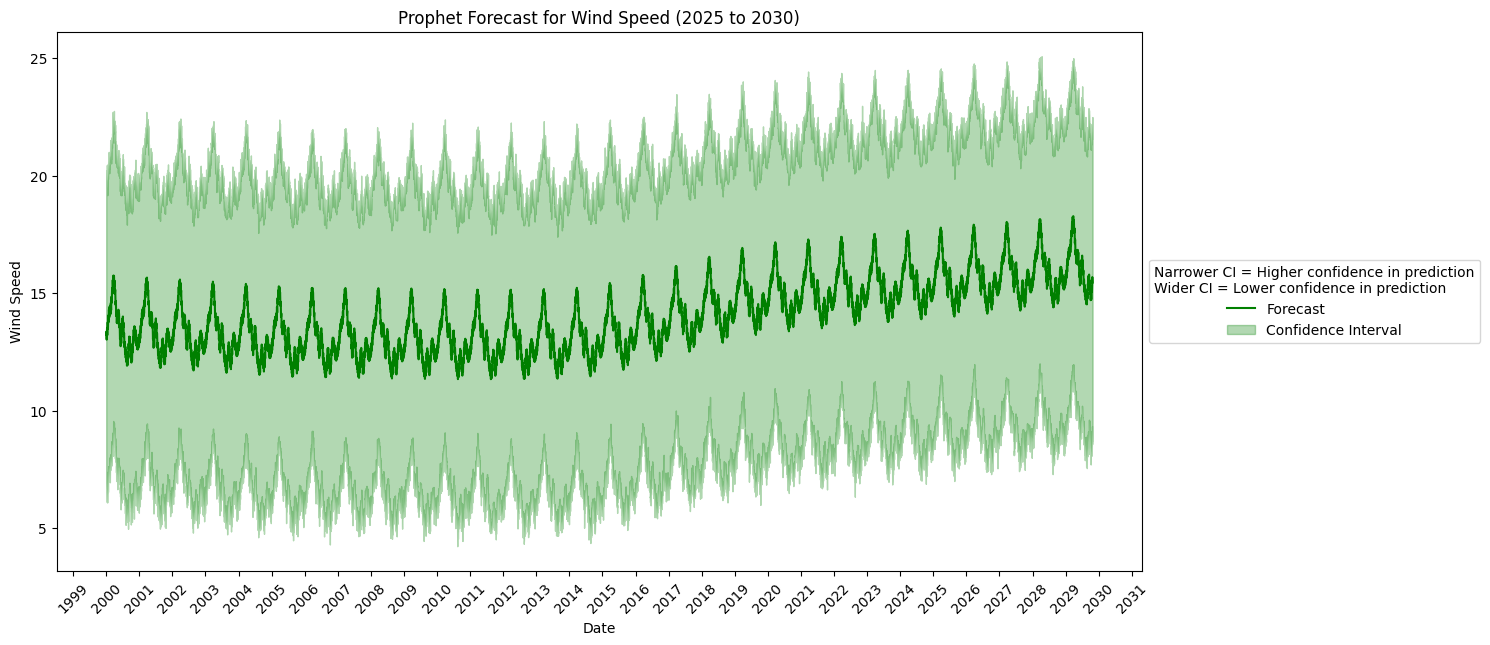

In [19]:
import sys
import pandas as pd
import numpy as np
import sqlite3
from prophet import Prophet
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import psutil

# Importing WeatherAnalyzer from the analyze_data script
sys.path.append('/workspaces/weather-scraper-analyzer/src/03-data_analysis')
from analyze_data import WeatherAnalyzer

# Setting up the connection to the database
conn = sqlite3.connect(r"/workspaces/weather-scraper-analyzer/data/weather_data.db")
daily_df = pd.read_sql(r"SELECT * FROM daily_data", conn)

# Dropping the index column and setting up the date
daily_df = daily_df.drop(columns='index')
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df = daily_df.set_index('date')
daily_df.index = pd.to_datetime(daily_df.index).to_period('D').to_timestamp()

# Initialize WeatherAnalyzer (if you need it for further analysis)
analyzer = WeatherAnalyzer(None, daily_df)

# Extract the necessary weather variables
variables = {
    "Temperature": daily_df['temperature_2m_mean_C'].dropna(),
    "Precipitation": daily_df['precipitation_sum_mm'].dropna(),
    "Wind Speed": daily_df['wind_speed_10m_max_kmh'].dropna()
}

# Function to log and display resource usage
def log_resource_usage(step):
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_info = psutil.virtual_memory()
    memory_usage = memory_info.percent
    print(f"[{step}] CPU Usage: {cpu_usage}% | Memory Usage: {memory_usage}%")

# Function to fit Prophet model
def fit_prophet_model(series, variable_name):
    # Preparing the data for Prophet
    df = series.reset_index()
    df.columns = ['ds', 'y']

    log_resource_usage(f"Before fitting Prophet model for {variable_name}")
    model = Prophet()
    model.fit(df)
    log_resource_usage(f"After fitting Prophet model for {variable_name}")

    # Forecast for the next 5 years
    future = model.make_future_dataframe(periods=5 * 365)
    forecast = model.predict(future)

    # Print confidence interval
    print(f"\n{variable_name} Forecast Confidence Interval (First 10 rows):")
    print(forecast[['ds', 'yhat_lower', 'yhat_upper']].head(10))

    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], variable_name

# Measure the start time and log initial resource usage
start_time = datetime.now()
log_resource_usage("Start of the process")

# Fitting Prophet model for each variable
prophet_results = {}
for var_name, series in variables.items():
    prophet_results[var_name] = fit_prophet_model(series, var_name)

# Measure the end time and print the duration and final resource usage
end_time = datetime.now()
print(f"Model fitting duration: {end_time - start_time}")
log_resource_usage("End of the process")

# Plotting Prophet Forecasts
for var_name, (forecast, _) in prophet_results.items():
    plt.figure(figsize=(14, 7))
    plt.plot(forecast['ds'], forecast['yhat'], color='green', label="Forecast")
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='green', alpha=0.3, label="Confidence Interval")
    plt.title(f"Prophet Forecast for {var_name} (2025 to 2030)")
    plt.xlabel("Date")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Show every year
    plt.xticks(rotation=45)
    plt.ylabel(var_name)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Narrower CI = Higher confidence in prediction\nWider CI = Lower confidence in prediction")
    plt.show()


**PROPHET with aggregated daily_df 'W'**

[Start of the process] CPU Usage: 2.4% | Memory Usage: 22.4%


08:45:40 - cmdstanpy - INFO - Chain [1] start processing
08:45:40 - cmdstanpy - INFO - Chain [1] done processing


[Before fitting Prophet model for Temperature] CPU Usage: 0.4% | Memory Usage: 22.4%
[After fitting Prophet model for Temperature] CPU Usage: 0.5% | Memory Usage: 22.4%

Temperature Forecast Confidence Interval (First 10 rows):
          ds  yhat_lower  yhat_upper
0 2000-01-02   -2.624396    4.473780
1 2000-01-09   -3.083834    4.391153
2 2000-01-16   -3.162022    4.134699
3 2000-01-23   -3.191816    4.055453
4 2000-01-30   -3.279568    4.348192
5 2000-02-06   -2.877940    4.756980
6 2000-02-13   -1.841685    5.640412
7 2000-02-20   -1.192218    6.373229
8 2000-02-27    0.040763    7.200057
9 2000-03-05    0.987195    8.148573


08:45:42 - cmdstanpy - INFO - Chain [1] start processing
08:45:42 - cmdstanpy - INFO - Chain [1] done processing


[Before fitting Prophet model for Precipitation] CPU Usage: 0.3% | Memory Usage: 22.3%
[After fitting Prophet model for Precipitation] CPU Usage: 0.4% | Memory Usage: 22.3%

Precipitation Forecast Confidence Interval (First 10 rows):
          ds  yhat_lower  yhat_upper
0 2000-01-02   -1.133623    4.046640
1 2000-01-09   -1.139259    3.830217
2 2000-01-16   -0.940132    3.992971
3 2000-01-23   -0.797288    4.270149
4 2000-01-30   -0.739684    4.207505
5 2000-02-06   -1.016221    3.918288
6 2000-02-13   -1.126779    3.776122
7 2000-02-20   -0.896370    3.906823
8 2000-02-27   -0.839065    4.297019
9 2000-03-05   -0.619146    4.523630


08:45:45 - cmdstanpy - INFO - Chain [1] start processing
08:45:45 - cmdstanpy - INFO - Chain [1] done processing


[Before fitting Prophet model for Wind Speed] CPU Usage: 0.2% | Memory Usage: 22.3%
[After fitting Prophet model for Wind Speed] CPU Usage: 0.2% | Memory Usage: 22.3%

Wind Speed Forecast Confidence Interval (First 10 rows):
          ds  yhat_lower  yhat_upper
0 2000-01-02    9.228695   16.613074
1 2000-01-09    9.200984   16.525069
2 2000-01-16    9.812091   17.135754
3 2000-01-23    9.938110   17.083622
4 2000-01-30   10.263025   17.533702
5 2000-02-06   10.223891   17.493669
6 2000-02-13   10.179530   17.857415
7 2000-02-20   10.310736   17.899803
8 2000-02-27   10.588012   17.851765
9 2000-03-05   10.924924   18.241755
Model fitting duration: 0:00:07.882693
[End of the process] CPU Usage: 1.0% | Memory Usage: 22.0%


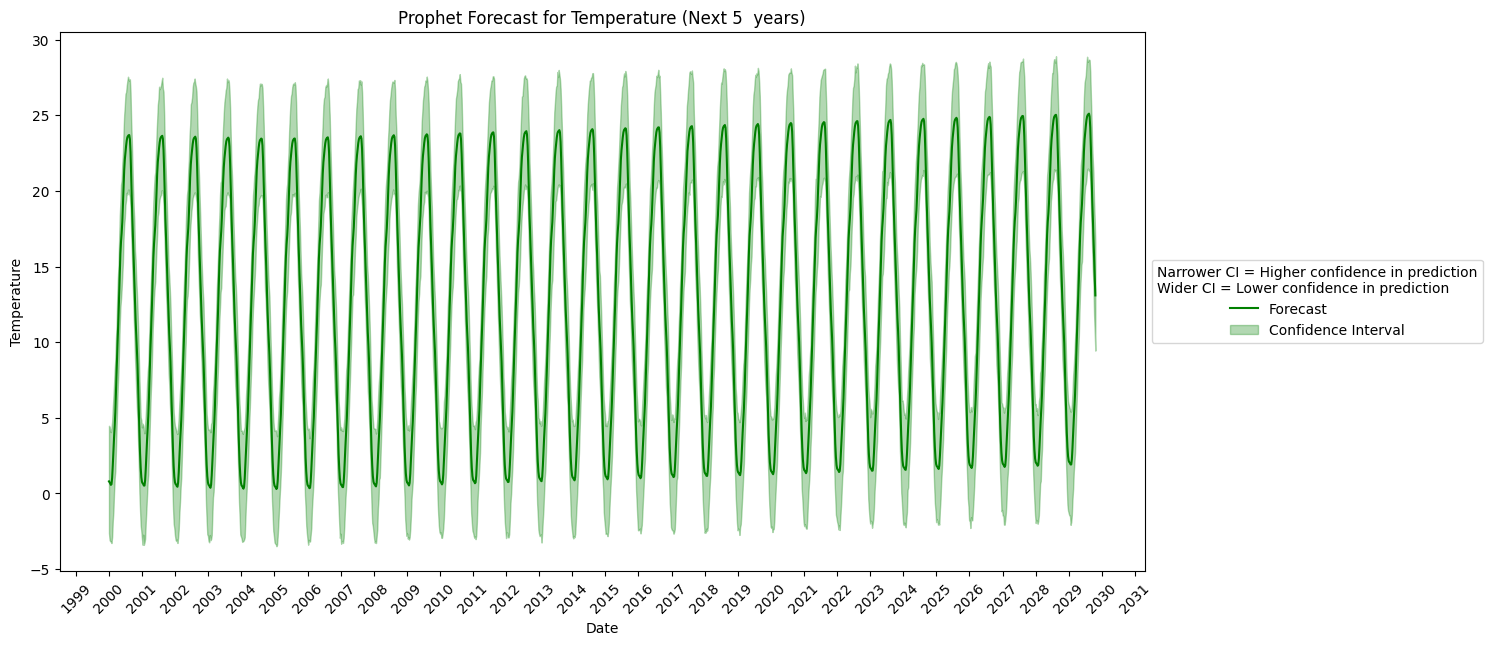

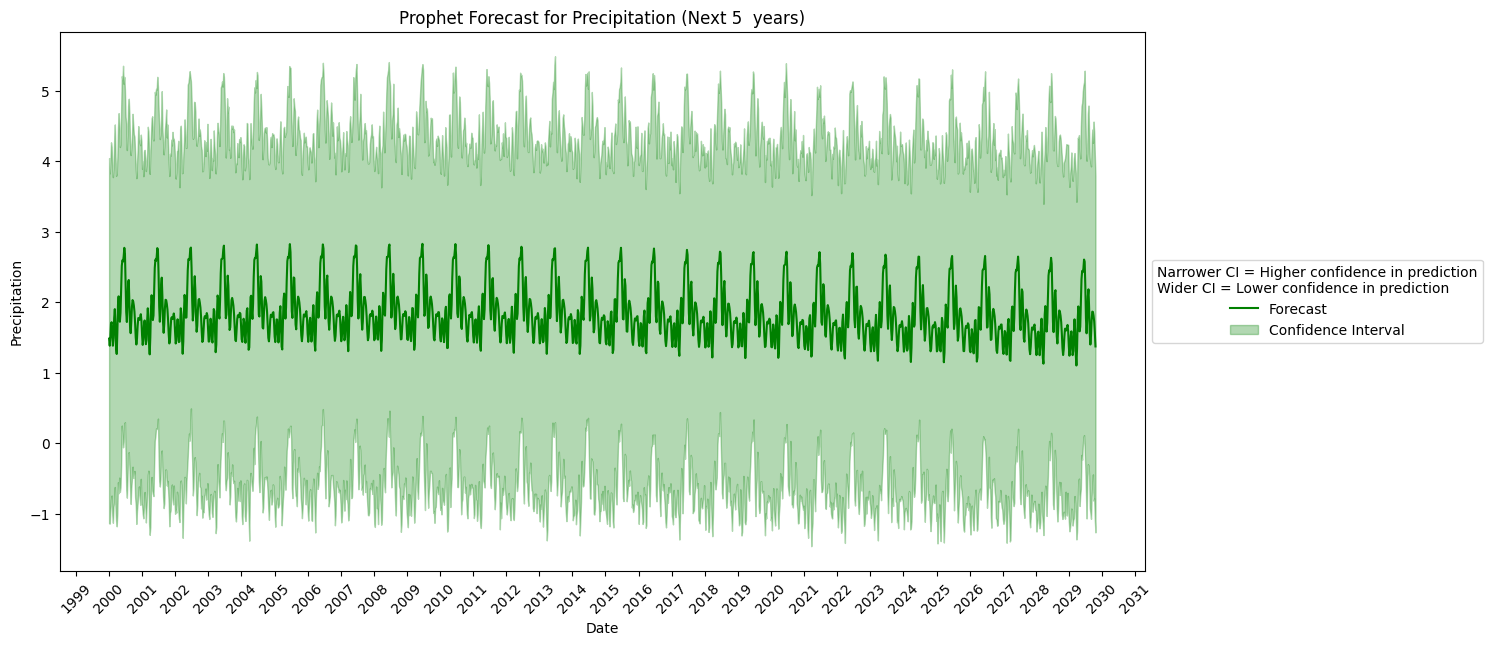

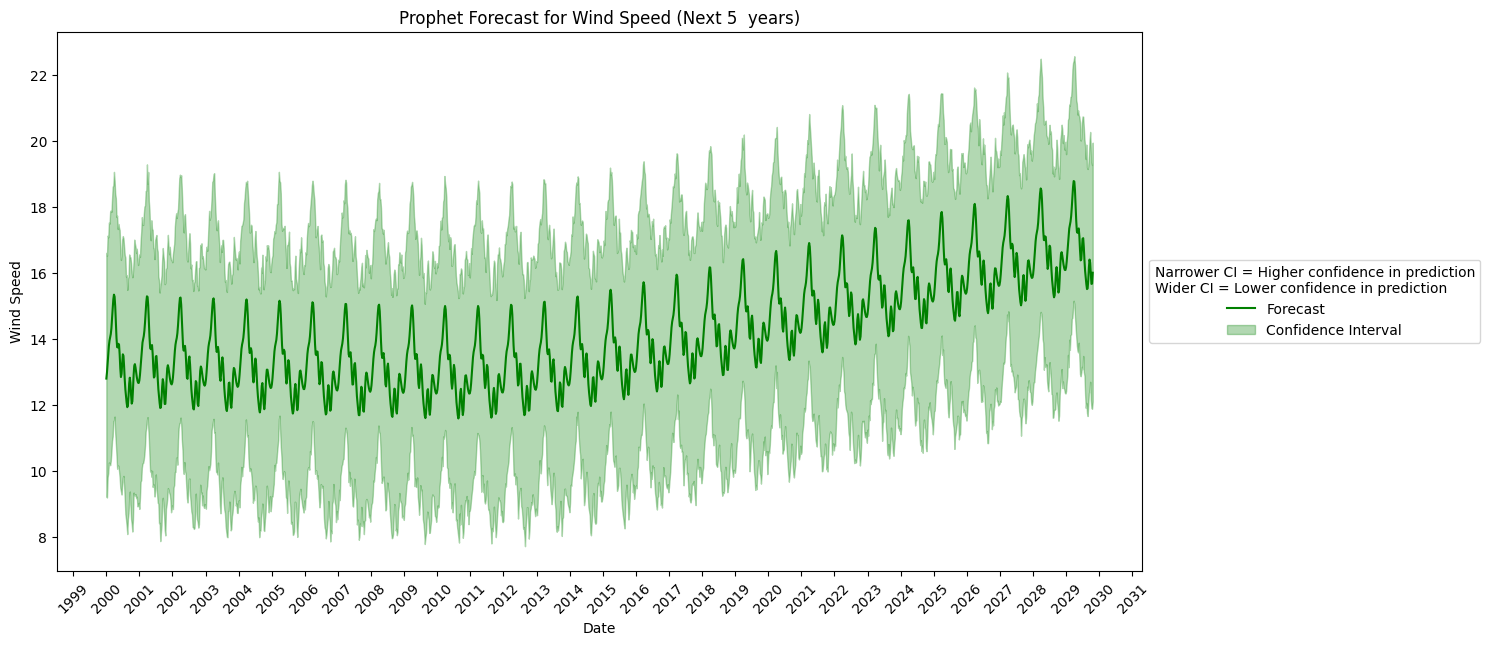

In [18]:
# Import necessary libraries
import sys
import pandas as pd
import sqlite3
from prophet import Prophet
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import psutil

# Importing WeatherAnalyzer from the analyze_data script
sys.path.append('/workspaces/weather-scraper-analyzer/src/03-data_analysis')
from analyze_data import WeatherAnalyzer

# Setting up the connection to the database and loading data
conn = sqlite3.connect(r"/workspaces/weather-scraper-analyzer/data/weather_data.db")
daily_df = pd.read_sql(r"SELECT * FROM daily_data", conn)

# Dropping the index column and setting up the date
daily_df = daily_df.drop(columns='index')
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df = daily_df.set_index('date')
daily_df.index = pd.to_datetime(daily_df.index).to_period('D').to_timestamp()

# Initialize WeatherAnalyzer and aggregate the data to weekly
analyzer = WeatherAnalyzer(None, daily_df)
weekly_daily = analyzer.aggregate_daily('W')

# Extract necessary variables from aggregated data (selecting 'mean' values only)
variables = {
    "Temperature": weekly_daily['temperature_2m_mean_C']['mean'].dropna(),
    "Precipitation": weekly_daily['precipitation_sum_mm']['mean'].dropna(),
    "Wind Speed": weekly_daily['wind_speed_10m_max_kmh']['mean'].dropna()
}

# Function to log and display resource usage
def log_resource_usage(step):
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_info = psutil.virtual_memory()
    memory_usage = memory_info.percent
    print(f"[{step}] CPU Usage: {cpu_usage}% | Memory Usage: {memory_usage}%")

# Function to fit Prophet model
def fit_prophet_model(series, variable_name):
    # Preparing the data for Prophet
    df = series.reset_index()
    df.columns = ['ds', 'y']

    log_resource_usage(f"Before fitting Prophet model for {variable_name}")
    model = Prophet()
    model.fit(df)
    log_resource_usage(f"After fitting Prophet model for {variable_name}")

    # Forecast for the next 5 years
    future = model.make_future_dataframe(periods=52*5, freq='W')
    forecast = model.predict(future)

    # Print confidence interval
    print(f"\n{variable_name} Forecast Confidence Interval (First 10 rows):")
    print(forecast[['ds', 'yhat_lower', 'yhat_upper']].head(10))

    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], variable_name

# Measure the start time and log initial resource usage
start_time = datetime.now()
log_resource_usage("Start of the process")

# Fitting Prophet models for each variable
prophet_results = []
for var_name, series in variables.items():
    forecast, variable_name = fit_prophet_model(series, var_name)
    prophet_results.append((forecast, variable_name))

# Measure the end time and print the duration and final resource usage
end_time = datetime.now()
print(f"Model fitting duration: {end_time - start_time}")
log_resource_usage("End of the process")

# Plotting Prophet Forecasts
for forecast, var_name in prophet_results:
    plt.figure(figsize=(14, 7))
    plt.plot(forecast['ds'], forecast['yhat'], color='green', label="Forecast")
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='green', alpha=0.3, label="Confidence Interval")
    plt.title(f"Prophet Forecast for {var_name} (Next 5  years)")
    plt.xlabel("Date")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Show every year
    plt.xticks(rotation=45)
    plt.ylabel(var_name)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Narrower CI = Higher confidence in prediction\nWider CI = Lower confidence in prediction")
    plt.show()
